In [1]:
# we need to read frames from the movie
# so we install opencv-python - change the next cell type to "Code"

In [2]:
import cv2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 12)

from skimage import exposure
from skimage import img_as_ubyte

In [4]:
from openpiv import pyprocess, piv, validation, tools, filters, scaling

In [5]:
def as_grey(frame):
    red = frame[:, :, 0]
    green = frame[:, :, 1]
    blue = frame[:, :, 2]
    im = np.ceil(0.2125 * red + 0.7154 * green + 0.0721 * blue).astype(np.uint8)
    im = exposure.equalize_adapthist(im,clip_limit=1.2)
    
    return img_as_ubyte(im)

In [6]:
# the video is the jet PIV from Youtube
# https://www.youtube.com/watch?v=EeS1rYMZUxI&ab_channel=USUExperimentalFluidDynamicsLab
# all the rights reserved to the authors

vidcap = cv2.VideoCapture('../test16/Night_time_lavaflow_trim.mov')
success, image1 = vidcap.read()
skip = 3
for i in range(skip):
    success, image2 = vidcap.read()
# count = 0
# U = []
# V = []

# plt.figure(figsize=(12,12))

# while success and count < 1:
#     # cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
#     success, image2 = vidcap.read()
#     # print('Read a new frame: ', success)
#     if success:
#         x,y,u,v = piv.simple_piv(image1.sum(axis=2), image2.sum(axis=2),plot=True);
#         # image1 = image2.copy()
#         count += 1
#         U.append(u)
#         V.append(v)

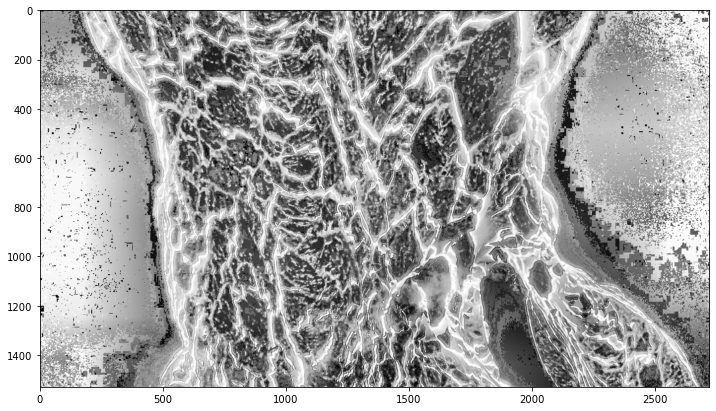

In [7]:
plt.imshow(as_grey(image1),cmap='gray')

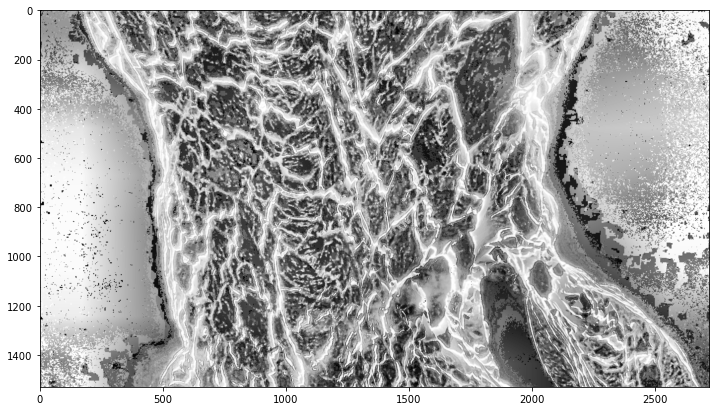

In [8]:
plt.imshow(as_grey(image2),cmap='gray')

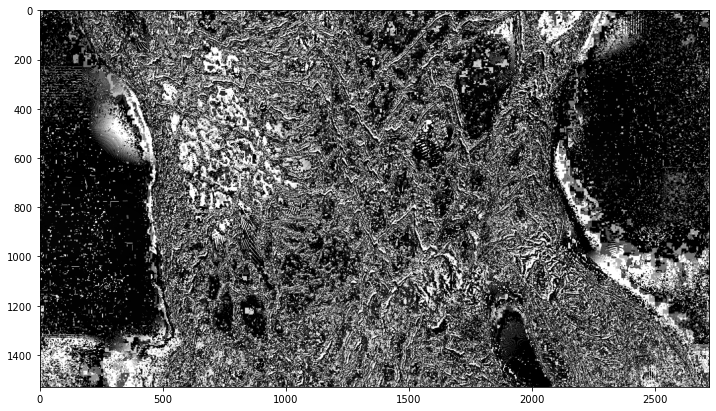

In [9]:
plt.imshow(as_grey(image2) - as_grey(image1),cmap='gray')

In [10]:
frame_a = as_grey(image1).astype(np.int32)
frame_b = as_grey(image2).astype(np.int32)

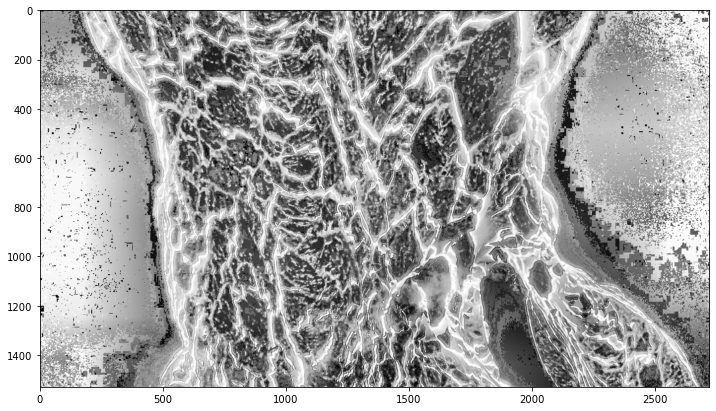

In [11]:
plt.imshow(frame_a,cmap='gray')

In [12]:
winsize = 64 # pixels, interrogation window size in frame A
searchsize = 128  # pixels, search in image B
overlap = 32 # pixels, 50% overlap
dt = 1 # sec, time interval between pulses


u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_a, 
                                                       frame_b, 
                                                       window_size=winsize, 
                                                       overlap=overlap, 
                                                       dt=dt, 
                                                       search_area_size=searchsize, 
                                                       sig2noise_method='peak2peak')

x, y = pyprocess.get_coordinates( image_size=frame_a.shape, 
                                 search_area_size=searchsize, 
                                 overlap=overlap )

u1, v1, mask = validation.sig2noise_val( u0, v0, 
                                        sig2noise, 
                                        threshold = 1.0)
# if you need more detailed look, first create a histogram of sig2noise
# plt.hist(sig2noise.flatten(),bins=100)
# to see where is a reasonable limit

# filter out outliers that are very different from the
# neighbours

u2, v2 = filters.replace_outliers( u1, v1, 
                                  method='localmean', 
                                  max_iter=3, 
                                  kernel_size=3)
# convert x,y to mm
# convert u,v to mm/sec

x, y, u3, v3 = scaling.uniform(x, y, u2, v2, 
                               scaling_factor = 1.0 ) 

# 0,0 shall be bottom left, positive rotation rate is counterclockwise
x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)

tools.save(x, y, u3, v3, mask, '../test16/night_lava_test.txt' )

tools.imsave('../test16/bkg.png',as_grey(image1))

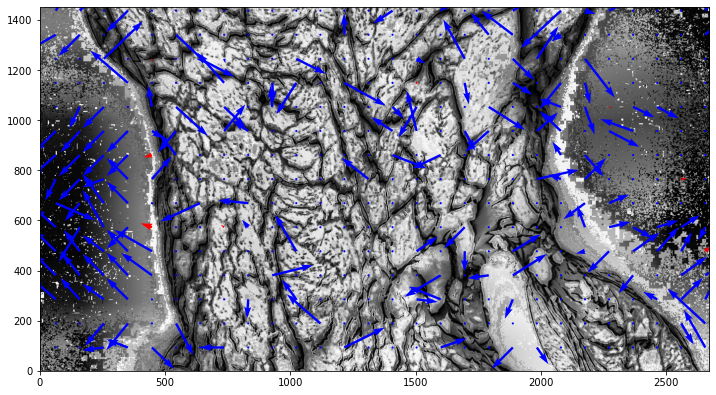

In [13]:
fig, ax = plt.subplots()

tools.display_vector_field('../test16/night_lava_test.txt', 
                           ax=ax, scaling_factor=1, 
                           scale=1000, # scale defines here the arrow length
                           width=0.0035, # width is the thickness of the arrow
                           on_img=True, # overlay on the image
                           image_name='../test16/bkg.png');

C:\Users\alex\miniconda3\envs\openpiv\lib\site-packages\matplotlib\quiver.py:679: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\alex\miniconda3\envs\openpiv\lib\site-packages\matplotlib\quiver.py:679: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


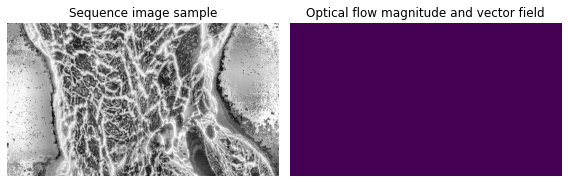

In [14]:
from skimage.registration import optical_flow_ilk
# --- Compute the optical flow


v, u = optical_flow_ilk(frame_a, frame_b, radius=15)

# --- Compute flow magnitude
norm = np.sqrt(u ** 2 + v ** 2)

# --- Display
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))

# --- Sequence image sample

ax0.imshow(frame_a, cmap='gray')
ax0.set_title("Sequence image sample")
ax0.set_axis_off()

# --- Quiver plot arguments

nvec = 20  # Number of vectors to be displayed along each image dimension
nl, nc = frame_a.shape
step = max(nl//nvec, nc//nvec)

y, x = np.mgrid[:nl:step, :nc:step]
u_ = u[::step, ::step]
v_ = v[::step, ::step]

ax1.imshow(norm)
ax1.quiver(x, y, u_, v_, color='r', units='dots',
           angles='xy', scale_units='xy', lw=3)
ax1.set_title("Optical flow magnitude and vector field")
ax1.set_axis_off()
fig.tight_layout()

plt.show()